## 1. Import Libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import pickle

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Word2Vec Embeddings

In [2]:
# Load embeddings and labels
embeddings_path = 'C:\\Users\\DELL\\Downloads\\aclImdb_v1\\aclImdb\\models\\word2vec\\document_embeddings.npy'
labels_path = 'C:\\Users\\DELL\\Downloads\\aclImdb_v1\\aclImdb\\models\\word2vec\\labels.npy'

print("Loading Word2Vec embeddings...")
X = np.load(embeddings_path)
y = np.load(labels_path)

print(f"\nEmbeddings shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
print(pd.Series(y).value_counts())
print(f"\nPositive: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")
print(f"Negative: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")

Loading Word2Vec embeddings...

Embeddings shape: (50000, 100)
Labels shape: (50000,)

Label distribution:
0    25000
1    25000
Name: count, dtype: int64

Positive: 25000 (50.00%)
Negative: 25000 (50.00%)


## 3. Define Hyperparameter Grids

In [6]:
# Logistic Regression - 20 combinations
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

# Random Forest - 20 combinations
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# AdaBoost - 20 combinations
ada_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# MLP (Neural Network as LSTM alternative) - 20 combinations
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

print("Hyperparameter grids defined:")
print(f"\nLogistic Regression: {sum([len(v) for v in lr_param_grid.values()])} parameters")
print(f"Random Forest: {sum([len(v) for v in rf_param_grid.values()])} parameters")
print(f"AdaBoost: {sum([len(v) for v in ada_param_grid.values()])} parameters")
print(f"MLP: {sum([len(v) for v in mlp_param_grid.values()])} parameters")

Hyperparameter grids defined:

Logistic Regression: 10 parameters
Random Forest: 12 parameters
AdaBoost: 11 parameters
MLP: 11 parameters


## 4. Logistic Regression - GridSearchCV

In [7]:
print("="*80)
print("1. LOGISTIC REGRESSION - Grid Search with 5-Fold CV")
print("="*80)

start_time = time.time()

# Create model
lr_model = LogisticRegression(random_state=42)

# Grid search with cross-validation
lr_grid = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nFitting Logistic Regression...")
lr_grid.fit(X, y)

lr_time = time.time() - start_time

print(f"\n{'='*80}")
print("Logistic Regression Results:")
print(f"{'='*80}")
print(f"Best CV Score: {lr_grid.best_score_:.4f}")
print(f"Best Parameters: {lr_grid.best_params_}")
print(f"Training Time: {lr_time:.2f} seconds")

# Get top 5 results
results_df = pd.DataFrame(lr_grid.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Configurations:")
print(top_5.to_string())

1. LOGISTIC REGRESSION - Grid Search with 5-Fold CV

Fitting Logistic Regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Logistic Regression Results:
Best CV Score: 0.8280
Best Parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Training Time: 867.22 seconds

Top 5 Configurations:
                                                                params  mean_test_score  std_test_score
16   {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}          0.82798        0.006668
20  {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}          0.82798        0.006668
17        {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}          0.82798        0.006649
21       {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}          0.82798        0.006649
18   {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}          0.82792        0.006600


## 5. Random Forest - GridSearchCV

In [9]:
print("\n" + "="*80)
print("2. RANDOM FOREST - Grid Search with 5-Fold CV")
print("="*80)

start_time = time.time()

# Create model
rf_model = RandomForestClassifier(random_state=42)

# Grid search with cross-validation
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nFitting Random Forest...")
rf_grid.fit(X, y)

rf_time = time.time() - start_time

print(f"\n{'='*80}")
print("Random Forest Results:")
print(f"{'='*80}")
print(f"Best CV Score: {rf_grid.best_score_:.4f}")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Training Time: {rf_time:.2f} seconds ({rf_time/60:.2f} minutes)")

# Get top 5 results
results_df = pd.DataFrame(rf_grid.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Configurations:")
print(top_5.to_string())


2. RANDOM FOREST - Grid Search with 5-Fold CV

Fitting Random Forest...
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Random Forest Results:
Best CV Score: 0.7886
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training Time: 5730.00 seconds (95.50 minutes)

Top 5 Configurations:
                                                                                     params  mean_test_score  std_test_score
31    {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}          0.78862        0.008107
51  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}          0.78786        0.006338
43    {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}          0.78776        0.007579
23    {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}          0.78752        0.006914
30    {'max_depth': 2

## 6. AdaBoost - GridSearchCV

In [10]:
print("\n" + "="*80)
print("3. ADABOOST - Grid Search with 5-Fold CV")
print("="*80)

start_time = time.time()

# Create model
ada_model = AdaBoostClassifier(random_state=42)

# Grid search with cross-validation
ada_grid = GridSearchCV(
    estimator=ada_model,
    param_grid=ada_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nFitting AdaBoost...")
ada_grid.fit(X, y)

ada_time = time.time() - start_time

print(f"\n{'='*80}")
print("AdaBoost Results:")
print(f"{'='*80}")
print(f"Best CV Score: {ada_grid.best_score_:.4f}")
print(f"Best Parameters: {ada_grid.best_params_}")
print(f"Training Time: {ada_time:.2f} seconds ({ada_time/60:.2f} minutes)")

# Get top 5 results
results_df = pd.DataFrame(ada_grid.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Configurations:")
print(top_5.to_string())


3. ADABOOST - Grid Search with 5-Fold CV

Fitting AdaBoost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

AdaBoost Results:
Best CV Score: 0.8011
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 400}
Training Time: 3520.17 seconds (58.67 minutes)

Top 5 Configurations:
                                                               params  mean_test_score  std_test_score
19  {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 400}          0.80108        0.006805
14  {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 400}          0.80038        0.006784
18  {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 300}          0.79932        0.008052
13  {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 300}          0.79602        0.006928
17  {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}          0.79460        0.008787


## 7. MLP (Neural Network) - GridSearchCV

In [11]:
print("\n" + "="*80)
print("4. MLP (Multi-Layer Perceptron) - Grid Search with 5-Fold CV")
print("="*80)

start_time = time.time()

# Create model
mlp_model = MLPClassifier(random_state=42, max_iter=500, early_stopping=True)

# Grid search with cross-validation
mlp_grid = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nFitting MLP...")
mlp_grid.fit(X, y)

mlp_time = time.time() - start_time

print(f"\n{'='*80}")
print("MLP Results:")
print(f"{'='*80}")
print(f"Best CV Score: {mlp_grid.best_score_:.4f}")
print(f"Best Parameters: {mlp_grid.best_params_}")
print(f"Training Time: {mlp_time:.2f} seconds ({mlp_time/60:.2f} minutes)")

# Get top 5 results
results_df = pd.DataFrame(mlp_grid.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Configurations:")
print(top_5.to_string())


4. MLP (Multi-Layer Perceptron) - Grid Search with 5-Fold CV

Fitting MLP...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

MLP Results:
Best CV Score: 0.8314
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Training Time: 219.15 seconds (3.65 minutes)

Top 5 Configurations:
                                                                                                  params  mean_test_score  std_test_score
2     {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}          0.83144        0.005262
3     {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}          0.83144        0.005262
4   {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}          0.83134        0.004925
5   {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_ra

## 8. Compare All Models

In [12]:
# Summary of all models
print("\n" + "="*80)
print("FINAL COMPARISON - Best Models")
print("="*80)

comparison_data = [
    {
        'Model': 'Logistic Regression',
        'Best CV Accuracy': lr_grid.best_score_,
        'Training Time (s)': lr_time,
        'Best Params': lr_grid.best_params_
    },
    {
        'Model': 'Random Forest',
        'Best CV Accuracy': rf_grid.best_score_,
        'Training Time (s)': rf_time,
        'Best Params': rf_grid.best_params_
    },
    {
        'Model': 'AdaBoost',
        'Best CV Accuracy': ada_grid.best_score_,
        'Training Time (s)': ada_time,
        'Best Params': ada_grid.best_params_
    },
    {
        'Model': 'MLP (Neural Net)',
        'Best CV Accuracy': mlp_grid.best_score_,
        'Training Time (s)': mlp_time,
        'Best Params': mlp_grid.best_params_
    }
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Best CV Accuracy', ascending=False)

print("\n" + comparison_df[['Model', 'Best CV Accuracy', 'Training Time (s)']].to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Best CV Accuracy']

print(f"\n🏆 WINNER: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


FINAL COMPARISON - Best Models

              Model  Best CV Accuracy  Training Time (s)
   MLP (Neural Net)           0.83144         219.150219
Logistic Regression           0.82798         867.219506
           AdaBoost           0.80108        3520.166348
      Random Forest           0.78862        5730.000576

🏆 WINNER: MLP (Neural Net)
   Accuracy: 0.8314 (83.14%)


## 9. Visualize Results

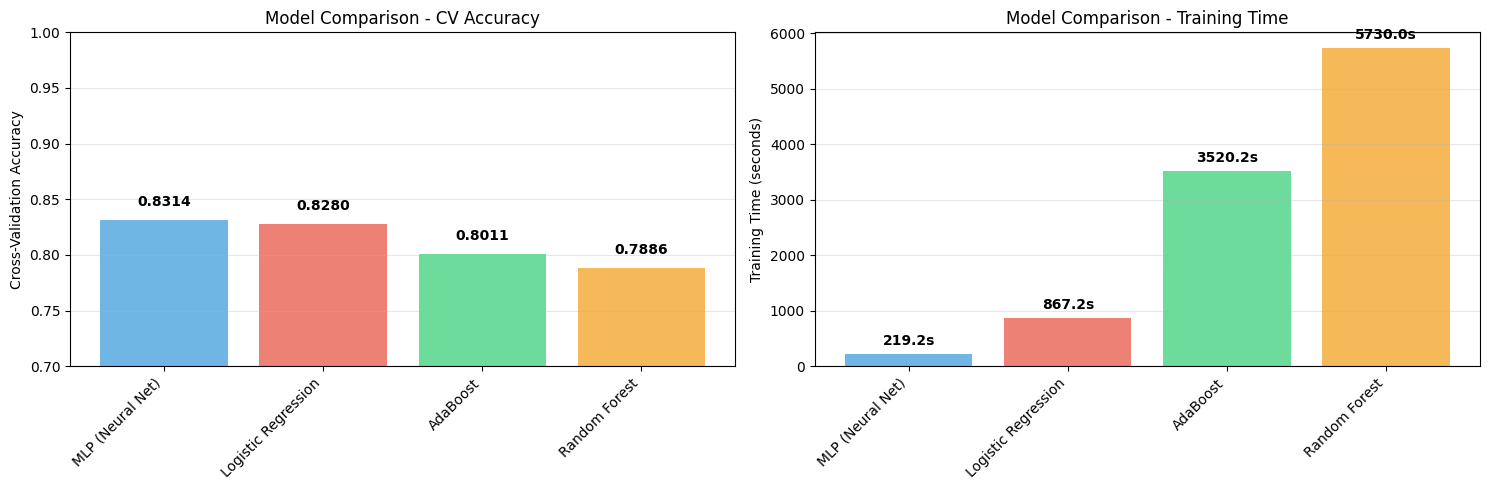


Visualization complete!


In [13]:
# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
models = comparison_df['Model'].values
accuracies = comparison_df['Best CV Accuracy'].values
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax1.bar(range(len(models)), accuracies, color=colors, alpha=0.7)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel('Cross-Validation Accuracy')
ax1.set_title('Model Comparison - CV Accuracy')
ax1.set_ylim([0.7, 1.0])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax1.text(bar.get_x() + bar.get_width()/2, acc + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison
times = comparison_df['Training Time (s)'].values
bars2 = ax2.bar(range(len(models)), times, color=colors, alpha=0.7)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Model Comparison - Training Time')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, t) in enumerate(zip(bars2, times)):
    ax2.text(bar.get_x() + bar.get_width()/2, t + max(times)*0.02, 
             f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

## 10. Detailed Results for Each Model

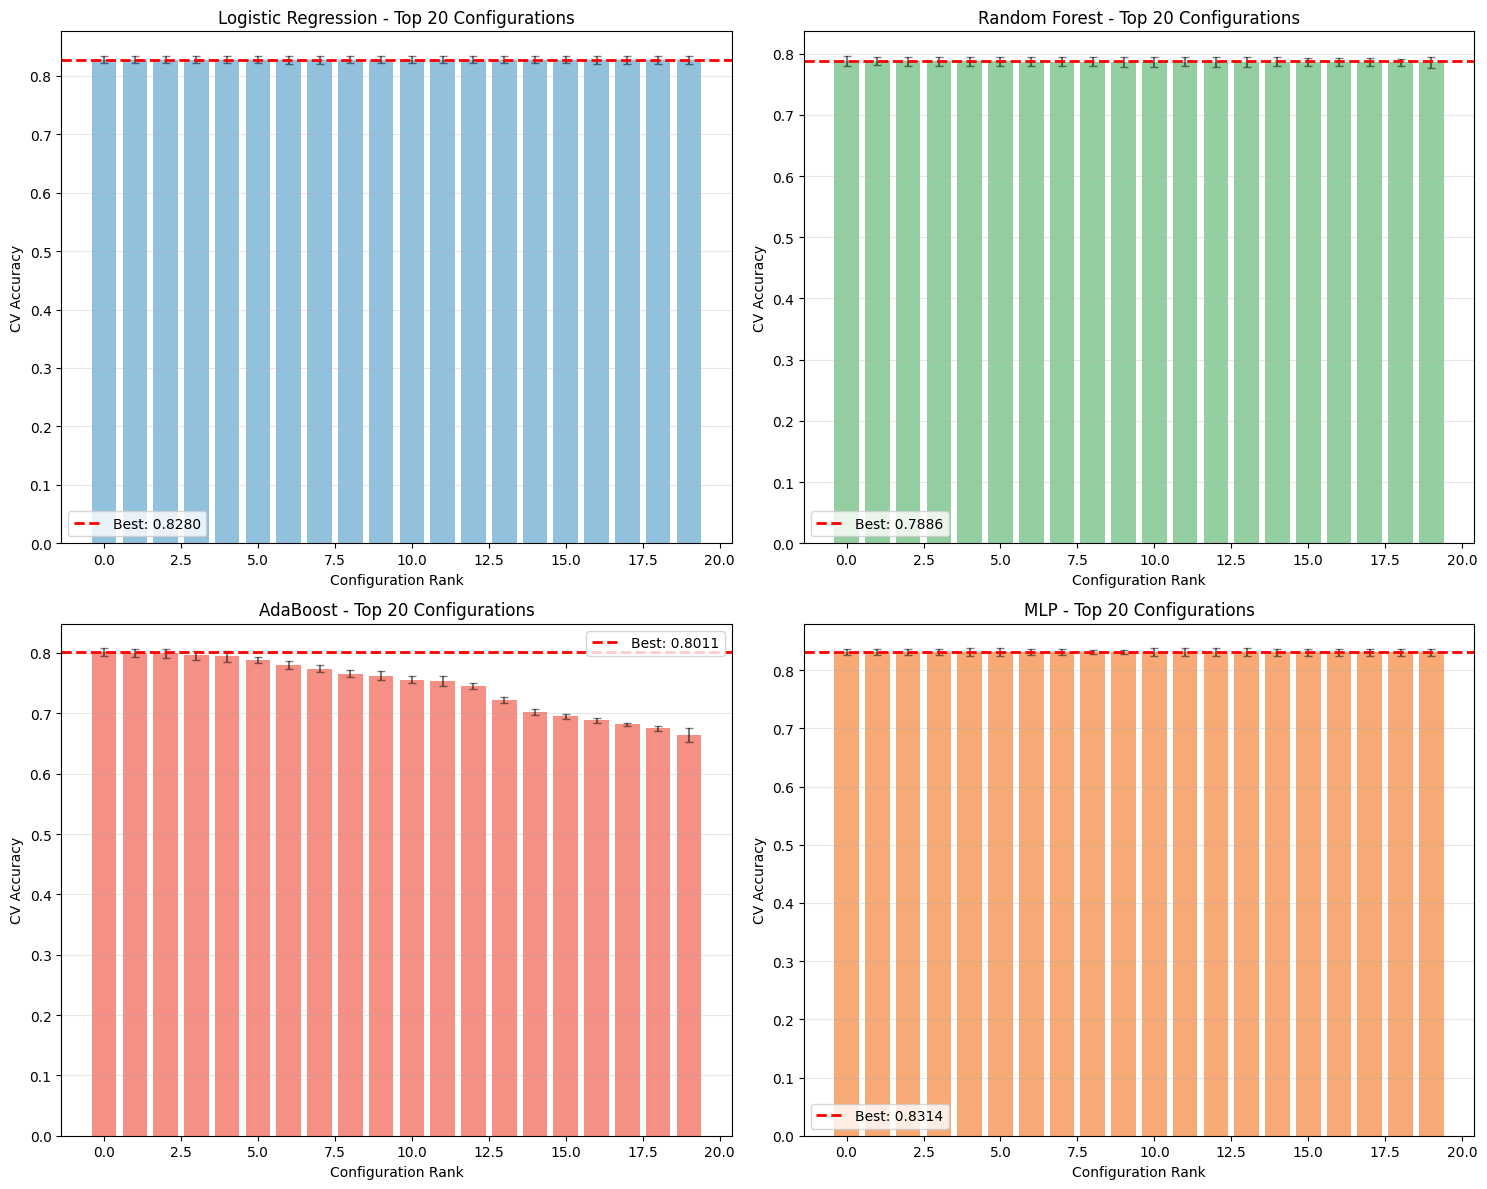

Detailed results plotted!


In [14]:
# Plot CV scores for each model
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

grids = [lr_grid, rf_grid, ada_grid, mlp_grid]
titles = ['Logistic Regression', 'Random Forest', 'AdaBoost', 'MLP']
colors_heat = ['Blues', 'Greens', 'Reds', 'Oranges']

for idx, (grid, title, cmap) in enumerate(zip(grids, titles, colors_heat)):
    results = pd.DataFrame(grid.cv_results_)
    top_20 = results.nlargest(20, 'mean_test_score')
    
    # Plot top 20 configurations
    x = range(len(top_20))
    y = top_20['mean_test_score'].values
    yerr = top_20['std_test_score'].values
    
    axes[idx].bar(x, y, alpha=0.6, color=plt.cm.get_cmap(cmap)(0.6))
    axes[idx].errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', alpha=0.5, capsize=3)
    axes[idx].set_xlabel('Configuration Rank')
    axes[idx].set_ylabel('CV Accuracy')
    axes[idx].set_title(f'{title} - Top 20 Configurations')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    axes[idx].axhline(y=grid.best_score_, color='red', linestyle='--', 
                      label=f'Best: {grid.best_score_:.4f}', linewidth=2)
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("Detailed results plotted!")

## 11. Save Best Models

In [16]:
import os

# Create output directory
output_dir = 'C:\\Users\\DELL\\Downloads\\aclImdb_v1\\aclImdb\\models/classifiers'
os.makedirs(output_dir, exist_ok=True)

# Save best models
models_to_save = [
    ('logistic_regression_best.pkl', lr_grid.best_estimator_),
    ('random_forest_best.pkl', rf_grid.best_estimator_),
    ('adaboost_best.pkl', ada_grid.best_estimator_),
    ('mlp_best.pkl', mlp_grid.best_estimator_)
]

print("Saving best models...\n")
for filename, model in models_to_save:
    path = os.path.join(output_dir, filename)
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ {filename}")

# Save comparison results
comparison_df.to_csv(os.path.join(output_dir, 'model_comparison.csv'), index=False)
print(f"\n✓ model_comparison.csv")

# Save detailed results
detailed_results = {
    'logistic_regression': pd.DataFrame(lr_grid.cv_results_),
    'random_forest': pd.DataFrame(rf_grid.cv_results_),
    'adaboost': pd.DataFrame(ada_grid.cv_results_),
    'mlp': pd.DataFrame(mlp_grid.cv_results_)
}

with pd.ExcelWriter(os.path.join(output_dir, 'detailed_results.xlsx')) as writer:
    for name, df in detailed_results.items():
        df.to_excel(writer, sheet_name=name, index=False)

print(f"✓ detailed_results.xlsx")

print(f"\n{'='*80}")
print(f"All models saved to: {output_dir}")
print(f"{'='*80}")

Saving best models...

✓ logistic_regression_best.pkl
✓ random_forest_best.pkl
✓ adaboost_best.pkl
✓ mlp_best.pkl

✓ model_comparison.csv


ModuleNotFoundError: No module named 'openpyxl'

## 12. Summary Report

In [17]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)

print(f"\n Dataset: {X.shape[0]:,} samples, {X.shape[1]} features (Word2Vec embeddings)")
print(f"\n Cross-Validation: 5-fold")
print(f"\n  Models Tested: 4")

print(f"\n Results (sorted by accuracy):\n")
for idx, row in comparison_df.iterrows():
    print(f"{idx+1}. {row['Model']:20s} - {row['Best CV Accuracy']:.4f} ({row['Best CV Accuracy']*100:.2f}%)")

print(f"\n Best Model: {best_model_name}")
print(f"   CV Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

best_params = comparison_df[comparison_df['Model'] == best_model_name]['Best Params'].values[0]
print(f"   Best Parameters:")
for param, value in best_params.items():
    print(f"     - {param}: {value}")

total_time = lr_time + rf_time + ada_time + mlp_time
print(f"\n Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print(f"\n Saved Files:")
print(f"   - Best models: {output_dir}/*.pkl")
print(f"   - Comparison: {output_dir}/model_comparison.csv")
print(f"   - Details: {output_dir}/detailed_results.xlsx")

print("\n" + "="*80)
print(" Hyperparameter tuning complete!")
print("="*80)


HYPERPARAMETER TUNING SUMMARY

 Dataset: 50,000 samples, 100 features (Word2Vec embeddings)

 Cross-Validation: 5-fold

  Models Tested: 4

 Results (sorted by accuracy):

4. MLP (Neural Net)     - 0.8314 (83.14%)
1. Logistic Regression  - 0.8280 (82.80%)
3. AdaBoost             - 0.8011 (80.11%)
2. Random Forest        - 0.7886 (78.86%)

 Best Model: MLP (Neural Net)
   CV Accuracy: 0.8314 (83.14%)
   Best Parameters:
     - activation: relu
     - alpha: 0.0001
     - hidden_layer_sizes: (100,)
     - learning_rate: constant

 Total Training Time: 10336.54 seconds (172.28 minutes)

 Saved Files:
   - Best models: C:\Users\DELL\Downloads\aclImdb_v1\aclImdb\models/classifiers/*.pkl
   - Comparison: C:\Users\DELL\Downloads\aclImdb_v1\aclImdb\models/classifiers/model_comparison.csv
   - Details: C:\Users\DELL\Downloads\aclImdb_v1\aclImdb\models/classifiers/detailed_results.xlsx

 Hyperparameter tuning complete!
